In [3]:
! pip install wfdb
! pip install tsfresh
#! pip install --upgrade pandas
#! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 KB 6.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import wfdb
import matplotlib.pyplot as plt
import pywt
import numpy as np
from wfdb import processing
import pandas as pd
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
import xgboost as xg
import pandas as pd
from sklearn import svm
#from catboost import CatBoostRegressor

In [ ]:
#!wget -r -N -c -np https://physionet.org/files/picsdb/1.0.0/

In [ ]:
data_dir = "/content/physionet.org/files/picsdb/1.0.0"

# Data Describion

In [ ]:
#basic information
ecp_resp_info = []
for i in range(1,11):
    ecg_record = wfdb.rdheader(f"{data_dir}/infant{i:d}_ecg")
    resp_record = wfdb.rdheader(f"{data_dir}/infant{i:d}_resp")
    ecg_data = ecg_record.__dict__
    resp_data = resp_record.__dict__
    
    ecg_second = ecg_data['sig_len']/ecg_data['fs']
    resp_second = resp_data['sig_len']/resp_data['fs']
    ecp_resp_info.append([ecg_data['record_name'], ecg_data['fs'], ecg_data['sig_len'], ecg_second, resp_data['record_name'], resp_data['fs'], resp_data['sig_len'], resp_second, round(resp_second-ecg_second)])
ecp_resp_info_df = pd.DataFrame(ecp_resp_info, columns=['EcgName', 'EcgFs', 'EcgSigLen', 'EcgTimeLen(s)', 'RespName', 'RespFs', 'RespSigLen', 'RespTimeLen(s)', 'TimeDiff'])

ecp_resp_info_df

,EcgName,EcgFs,EcgSigLen,EcgTimeLen(s),RespName,RespFs,RespSigLen,RespTimeLen(s),TimeDiff
0,infant1_ecg,250,41052191,164208.764,infant1_resp,500,82122000,164244.00,35
1,infant2_ecg,500,78916000,157832.000,infant2_resp,50,7891433,157828.66,-3
2,infant3_ecg,500,78684614,157369.228,infant3_resp,50,7868296,157365.92,-3
3,infant4_ecg,500,84208000,168416.000,infant4_resp,50,8420800,168416.00,0
4,infant5_ecg,250,43878723,175514.892,infant5_resp,50,8955598,179111.96,3597
5,infant6_ecg,500,87492197,174984.394,infant6_resp,50,8749057,174981.14,-3
6,infant7_ecg,500,36604500,73209.000,infant7_resp,50,3660288,73205.76,-3
7,infant8_ecg,500,44288000,88576.000,infant8_resp,50,4428613,88572.26,-4
8,infant9_ecg,500,126569088,253138.176,infant9_resp,50,12656784,253135.68,-2
9,infant10_ecg,500,85083254,170166.508,infant10_resp,50,8508154,170163.08,-3


#Data Analysis and Preprocess

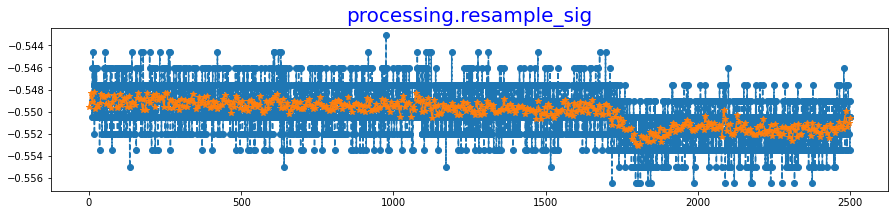

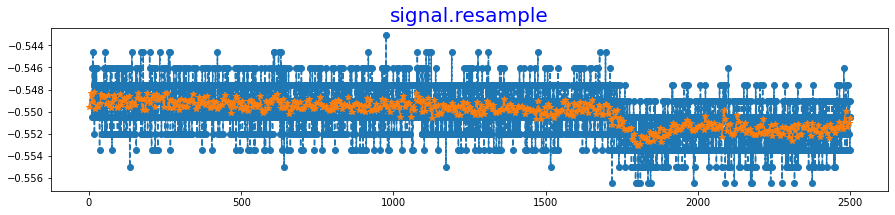

82122000 <class 'numpy.ndarray'>


In [ ]:
#Sampling the resp data of infant1, unified to 50Hz
resp_record = wfdb.rdsamp(f"{data_dir}/infant1_resp")
data_array = resp_record[0]
subdata = data_array[2000:7000].reshape(5000)

#method1
re_x2 = processing.resample_sig(subdata, 500, 50)

t = np.linspace(10,2500,5000)
x = subdata
plt.figure(figsize=(15.0, 3.0))
plt.plot(t,x,'o--',label='raw')

t1 = np.linspace(1, 2500, 500,endpoint=True)
plt.title("processing.resample_sig", size=20, color="blue")
plt.plot(t1,re_x2[0],'*--',label='resample')
plt.show()

plt.figure(figsize=(15.0, 3.0))
plt.plot(t,x,'o--',label='raw')

#使用resample
re_x = signal.resample(x,500)
t1 = np.linspace(1, 2500, 500,endpoint=True)
plt.title("signal.resample", size=20, color="blue")
plt.plot(t1,re_x,'*--',label='resample')
plt.show()


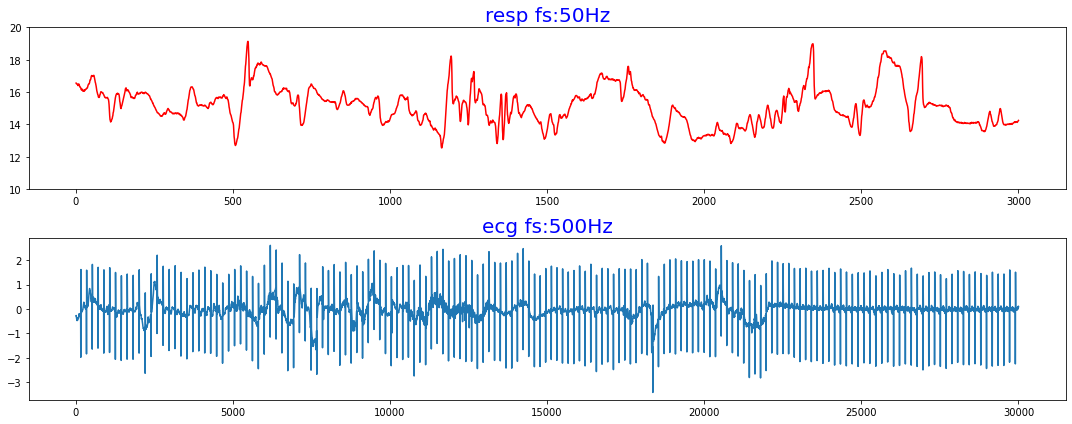

In [ ]:
#Align ecg and resp data
resp4_record = wfdb.rdsamp(f"{data_dir}/infant4_resp")
data4_array = resp4_record[0]
subdata2 = data4_array[1500:4500].reshape(3000)

part1_dat =  wfdb.rdrecord(f"{data_dir}/infant4_ecg")
part1_dat_data = part1_dat.__dict__
psignal = part1_dat_data["p_signal"][20000:50000].reshape(30000)
plt.figure(figsize=(15,6))
ax0 = plt.subplot(211)

t = np.linspace(1,3000,3000)
x = subdata2
#ax0.figure(figsize=(15.0, 3.0))
ax0.set_ylim((10, 20))
ax0.plot(t,x, color='r', label="method1")
ax0.set_title("resp fs:50Hz", size=20, color="blue")
#ax0.show()

ax1 = plt.subplot(212)
#plt.figure(figsize=(15.0, 3.0))
t1 = np.linspace(10, 30000, 30000,endpoint=True)
ax1.plot(t1, psignal, label='resample')
#plt.legend(loc="best")
ax1.set_title("ecg fs:500Hz", size=20, color="blue")
plt.tight_layout()
plt.show()

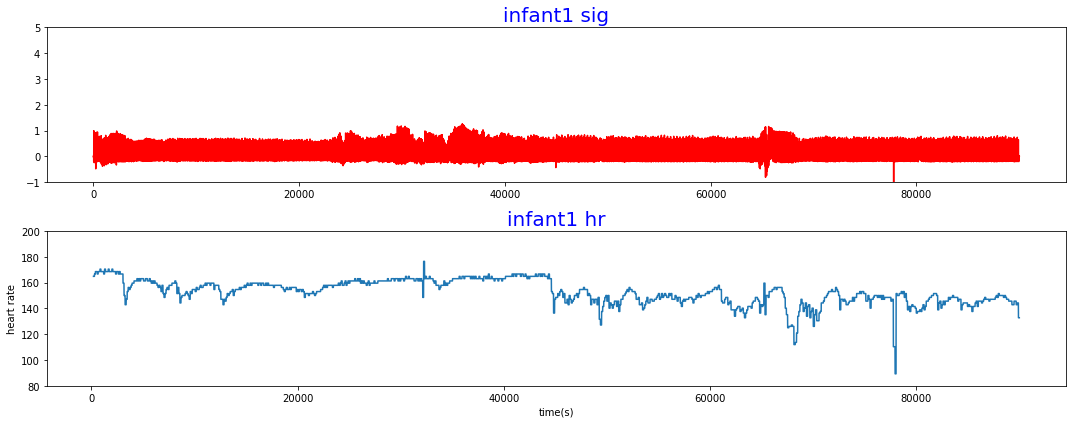

In [ ]:
#calculate heart rate from ecg
ecg_record = wfdb.rdrecord(f"{data_dir}/infant1_ecg", sampfrom=10000, sampto=100000, channels=[0])
sig = ecg_record.p_signal
fs = ecg_record.fs
qrs_inds = processing.qrs.gqrs_detect(sig=ecg_record.p_signal[:,0], fs=fs)
# compute hr
hrs = processing.hr.compute_hr(sig_len=sig.shape[0], qrs_inds=qrs_inds, fs=fs)


plt.figure(figsize=(15,6))
ax0 = plt.subplot(211)

t = np.linspace(1,90000,90000)
x = sig
#ax0.figure(figsize=(15.0, 3.0))
ax0.set_ylim((-1, 5))
ax0.plot(t,x, color='r', label="method1")
ax0.set_title("infant1 sig", size=20, color="blue")
#ax0.show()

ax1 = plt.subplot(212)
#plt.figure(figsize=(15.0, 3.0))
t1 = np.linspace(1, 90000, 90000,endpoint=True)
ax1.set_ylim((80, 200))
ax1.set_xlabel("time(s)")
ax1.set_ylabel("heart rate")
ax1.plot(t1, hrs, label='resample')
#plt.legend(loc="best")
ax1.set_title("infant1 hr", size=20, color="blue")
plt.tight_layout()
plt.show()

In [ ]:
#原始样本生成，现在resp和ecg数据对齐，通过ecg计算出hr，所以可以实现resp和hr的对齐，可以生成原始样本，每个infant单独生成一个样本集合，这样有10个集合，这部分没法画图说明

#数据处理，原始样本生成后，但是特征（resp）和target（hr）有脏数据，因此从特征和target两部分进行处理，有问题的样本直接删除处理

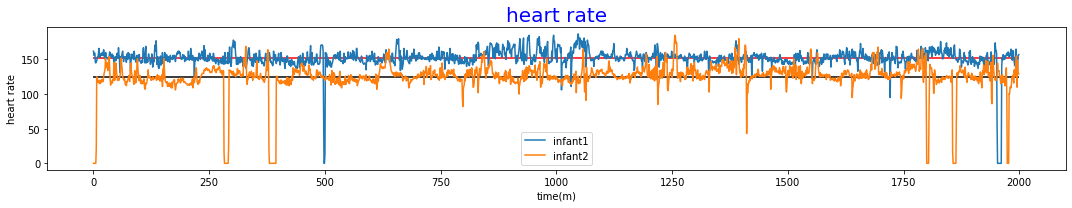

In [ ]:
#As can be seen from the figure below, the heart rate range of each infant is different, so the heartbeat data is processed separately
hr2, hr1 = [], []
for line in open(f"{data_dir}/infant2_ori_sample.txt"):
    f = line.strip().split('\t')
    if len(f) != 4:continue
    if len(hr2) >= 2000:continue
    hr2.append(int(f[1]))
    
for line in open(f"{data_dir}/infant1_ori_sample.txt"):
    f = line.strip().split('\t')
    if len(f) != 4:continue
    if len(hr1) >= 2000:continue
    hr1.append(int(f[1]))

plt.figure(figsize=(15.0, 3.0))
plt.title("heart rate", size=20, color="blue")
plt.xlabel("time(m)")
plt.ylabel("heart rate")
plt.hlines(sum(hr1)/len(hr1),0, 2000, linestyles='-', colors="red")
plt.hlines(sum(hr2)/len(hr2),0, 2000, linestyles='-', colors="black")
plt.plot(hr1, label='infant1')
plt.plot(hr2, label='infant2')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

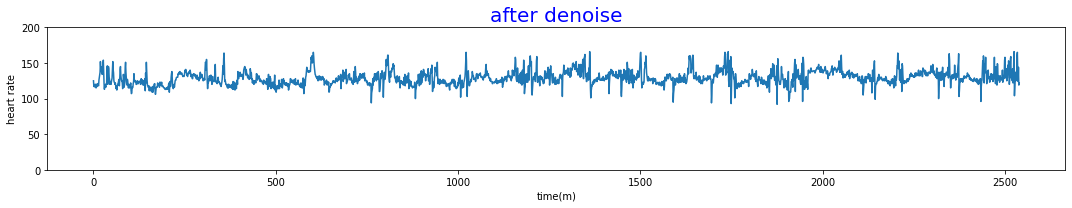

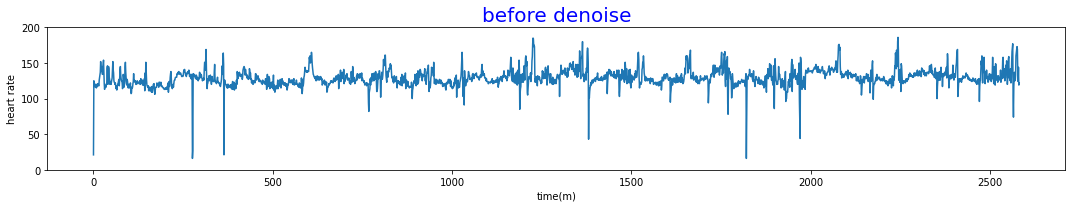

In [ ]:
#Use the z-score method to identify and delete abnormal data
hr2, hr1 = [], []
for line in open(f"{data_dir}/infant2_ori_sample.txt"):
    f = line.strip().split('\t')
    if len(f) != 4:continue
    hr = int(f[1])
    if hr < 10:continue
    hr2.append(hr)
    
std_hr = np.std(hr2)
mean_hr = np.mean(hr2)

hr1 = [h for h in hr2 if -3 < (h - mean_hr)/std_hr < 3]


plt.figure(figsize=(15.0, 3.0))
plt.ylim((0,200))
plt.xlabel("time(m)")
plt.ylabel("heart rate")
plt.title("after denoise", size=20, color="blue")
plt.plot(hr1)
plt.tight_layout()
plt.show()


plt.figure(figsize=(15.0, 3.0))
plt.ylim((0,200))
plt.xlabel("time(m)")
plt.ylabel("heart rate")
plt.title("before denoise", size=20, color="blue")
plt.plot(hr2)
plt.tight_layout()
plt.show()

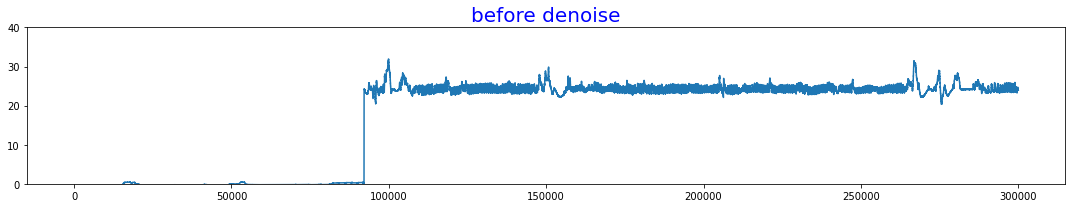

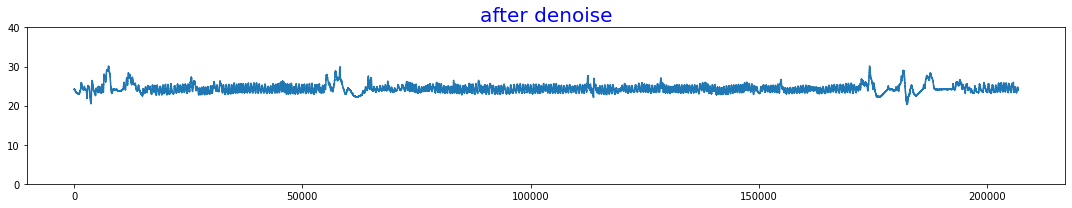

In [ ]:
#Similarly, the resp data also needs to be processed separately, also using the z-score method
resp_record = wfdb.rdsamp(f"{data_dir}/infant1_resp")

resp_array = [h[0] for h in resp_record[0][:300000] if h[0]>10]

std_hr = np.std(resp_array)
mean_hr = np.mean(resp_array)

hr1 = [h for h in resp_array if -5 < (h - mean_hr)/std_hr < 5]

plt.figure(figsize=(15.0, 3.0))
plt.ylim((0,40))
plt.title("before denoise", size=20, color="blue")

plt.plot(resp_record[0][:300000])

plt.tight_layout()
plt.show()

plt.figure(figsize=(15.0, 3.0))
plt.ylim((0,40))
plt.title("after denoise", size=20, color="blue")

plt.plot(hr1)

plt.tight_layout()
plt.show()

# Create Sample

In [ ]:
for i in range(1,11):
    
    fsw = open(f"{data_dir}/infant{i:d}_ori_sample2.txt", "w")
    
    ecg_fs = 250 if i in {1,5} else 500
    ecg_record = wfdb.rdrecord(f"{data_dir}/infant{i:d}_ecg", sampfrom=0, sampto=ecg_fs*60*60*3, channels=[0])

    sig = ecg_record.p_signal
    fs = ecg_record.fs
    resp_fs = 500 if i == 1 else 50
    resp_record = wfdb.rdrecord(f"{data_dir}/infant{i:d}_resp", sampfrom=0, sampto=resp_fs*60*60*3, channels=[0])
    
    resp_sig = resp_record.p_signal
    real_resp_fs = resp_record.fs
    
    print (i, "ecg_fs: ", ecg_fs, " sig: ", sig.shape, " ecg_real_fs: ", fs, "resp_fs: ", resp_fs, " resp_sig: ", resp_sig.shape, " resp_real_fs: ", real_resp_fs)
    
    qrs_inds = processing.qrs.gqrs_detect(sig=ecg_record.p_signal[:,0], fs=fs)
    # compute hr
    hrs = processing.hr.compute_hr(sig_len=sig.shape[0], qrs_inds=qrs_inds, fs=fs)
    
    hr_sample = hrs[::int(fs/50)]
    resp_sample = resp_sig[::int(real_resp_fs/50)]
    
    print (i," hrs number: ", len(hrs), " hr_sample: ", len(hr_sample), " resp_sample: ", len(resp_sample))
    
    for m in range(len(hr_sample)):
        fsw.write(str(hr_sample[m]) + '\t' + str(resp_sample[m]) + '\n')
    
    fsw.close()

1 ecg_fs:  250  sig:  (2700000, 1)  ecg_real_fs:  250 resp_fs:  500  resp_sig:  (5400000, 1)  resp_real_fs:  500
1  hrs number:  2700000  hr_sample:  540000  resp_sample:  540000
2 ecg_fs:  500  sig:  (5400000, 1)  ecg_real_fs:  500 resp_fs:  50  resp_sig:  (540000, 1)  resp_real_fs:  50
2  hrs number:  5400000  hr_sample:  540000  resp_sample:  540000
3 ecg_fs:  500  sig:  (5400000, 1)  ecg_real_fs:  500 resp_fs:  50  resp_sig:  (540000, 1)  resp_real_fs:  50
3  hrs number:  5400000  hr_sample:  540000  resp_sample:  540000
4 ecg_fs:  500  sig:  (5400000, 1)  ecg_real_fs:  500 resp_fs:  50  resp_sig:  (540000, 1)  resp_real_fs:  50
4  hrs number:  5400000  hr_sample:  540000  resp_sample:  540000
5 ecg_fs:  250  sig:  (2700000, 1)  ecg_real_fs:  250 resp_fs:  50  resp_sig:  (540000, 1)  resp_real_fs:  50
5  hrs number:  2700000  hr_sample:  540000  resp_sample:  540000
6 ecg_fs:  500  sig:  (5400000, 1)  ecg_real_fs:  500 resp_fs:  50  resp_sig:  (540000, 1)  resp_real_fs:  50
6  hrs 

#Create Model and Evaluate

In [5]:
#Load Data
resps_hr = []
for infant_num in range(1,11):
  hr_all, resp_all = [],[]
  #for line in open(f"{data_dir}/infant{infant_num:d}_ori_sample2.txt"):
  for line in open(f"sample_data/infant{infant_num:d}_ori_sample2.txt"):
      f = line.strip().split('\t')
      if len(f) != 2:continue
      hr, resp = f[0], eval(f[1])
      if hr == "nan": continue
      hr_all.append(float(hr))
      resp_all.append(resp[0])

  hr_std = np.std([rd for rd in hr_all if rd > 80])
  hr_mean = np.mean([rd for rd in hr_all if rd > 80])
  hr_min_thr = hr_mean - 3*hr_std
  hr_max_thr = hr_mean + 3*hr_std
  print (hr_std, hr_mean, hr_min_thr, hr_max_thr)

  resp_std = np.std([rd for rd in resp_all if rd > 10])
  resp_mean = np.mean([rd for rd in resp_all if rd > 10])
  resp_min_thr = resp_mean - 4*resp_std
  resp_max_thr = resp_mean + 4*resp_std
  print (resp_std, resp_mean, resp_min_thr, resp_max_thr)

  #----------------------------------------------------------

  resp_hr = []
  for m in range(len(hr_all)):
    if hr_min_thr < hr_all[m] < hr_max_thr:
      #resp_hr.append([hr_all[m], resp_all[m]])
      if resp_min_thr < resp_all[m] < resp_max_thr:
        resp_hr.append([hr_all[m], resp_all[m]])
      #if len(resp_hr) == 3000000: break
  print (len(resp_hr))

  #----------------------------------------------------------

  base_hr = 0
  empty_resp = []
  for item in resp_hr[20000:200000]:
      _hr, _resp = item
      if _hr != base_hr:
          if empty_resp:
              resps_hr.append([base_hr, empty_resp])
          empty_resp = []
          base_hr = _hr
          empty_resp.append(_resp)
      else:
          empty_resp.append(_resp)
          
  resps_hr.append([base_hr, empty_resp])
  print (len(resps_hr))
  print (resps_hr[0])
  #----------------------------------------------------------



10.388561001436818 151.09427584320053 119.92859283889008 182.25995884751097
1.848890798318872 24.332021006406194 16.936457813130705 31.727584199681683
1746207
5667
[148.51485, [23.60870834, 23.70493949, 23.7989327, 23.93843057, 24.07718245, 24.26367693, 24.31664136, 24.50835768, 24.64636359, 24.78809938, 24.97608581, 25.02457438, 25.21778265, 25.35728052, 25.44754384, 25.54302901, 25.59151757, 25.63553027, 25.64000614, 25.59450149]]
18.54963934297038 127.71436213922678 72.06544411031564 183.36328016813792
1.501283694039473 23.198021170083624 17.192886393925733 29.203155946241516
1693286
12345
[148.51485, [23.60870834, 23.70493949, 23.7989327, 23.93843057, 24.07718245, 24.26367693, 24.31664136, 24.50835768, 24.64636359, 24.78809938, 24.97608581, 25.02457438, 25.21778265, 25.35728052, 25.44754384, 25.54302901, 25.59151757, 25.63553027, 25.64000614, 25.59450149]]
13.144292236576822 126.92665935485654 87.49378264512607 166.35953606458702
1.2306439606730928 22.253486249656348 17.33091040696

In [6]:
infant_content = {"infant1":[0, 5667], "infant2":[5667, 12345], "infant3":[12345, 18627], "infant4":[18627, 25797], "infant5":[25797, 27451], "infant6":[27451, 33505], "infant7":[33505, 40923], "infant8":[40923, 47429], "infant9":[47429, 53657], "infant10":[53657, 61083]}

In [7]:
hr_y_list, resp_x_list = [], [[], []]
startid = 0
filename = ""
for _index in range(len(resps_hr)):
  _hr, _resps_list = resps_hr[_index]
  if len(_resps_list) < 27:continue
  hr_y_list.append(_hr)
  if infant_content["infant1"][0] <= _index < infant_content["infant1"][1]:
    filename = "infant1_"
  elif infant_content["infant2"][0] <= _index < infant_content["infant2"][1]:
    filename = "infant2_"
  elif infant_content["infant3"][0] <= _index < infant_content["infant3"][1]:
    filename = "infant3_"
  elif infant_content["infant4"][0] <= _index < infant_content["infant4"][1]:
    filename = "infant4_"
  elif infant_content["infant5"][0] <= _index < infant_content["infant5"][1]:
    filename = "infant5_"
  elif infant_content["infant6"][0] <= _index < infant_content["infant6"][1]:
    filename = "infant6_"
  elif infant_content["infant7"][0] <= _index < infant_content["infant7"][1]:
    filename = "infant7_"
  elif infant_content["infant8"][0] <= _index < infant_content["infant8"][1]:
    filename = "infant8_"
  elif infant_content["infant9"][0] <= _index < infant_content["infant9"][1]:
    filename = "infant9_"
  elif infant_content["infant10"][0] <= _index < infant_content["infant10"][1]:
    filename = "infant10_"
  resp_x_list[0].extend(_resps_list)
  resp_x_list[1].extend([filename + str(startid)] * len(_resps_list))
  startid += 1

In [8]:
c = {"resp":resp_x_list[0], "id":resp_x_list[1], "time":[i for i in range(len(resp_x_list[0]))]}
dfx = pd.DataFrame(c)
dfx

,resp,id,time
0,23.280478,infant1_0,0
1,23.326729,infant1_0,1
2,23.322253,infant1_0,2
3,23.272272,infant1_0,3
4,23.322253,infant1_0,4
...,...,...,...
655693,33.543958,infant10_13436,655693
655694,33.092482,infant10_13436,655694
655695,32.966793,infant10_13436,655695
655696,32.966793,infant10_13436,655696


In [9]:
#extract features
%matplotlib inline

import matplotlib.pylab as plt

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
def extract_udf(_df):
  extraction_settings = ComprehensiveFCParameters()
  X = extract_features(_df, column_id='id', column_sort='time', default_fc_parameters=extraction_settings, impute_function=impute)
  return X

ERROR:numba.cuda.cudadrv.driver:Call to cuInit results in CUDA_ERROR_NO_DEVICE


In [10]:
X = extract_udf(dfx)
print (X.shape)

Feature Extraction: 100%|██████████| 13437/13437 [14:24<00:00, 15.54it/s]


(13437, 783)


In [11]:
dfid = pd.DataFrame(dfx["id"])
dfid.drop_duplicates("id", keep='first', inplace=True)

dfid["y"] = hr_y_list
print (dfid.shape)
dfid


(13437, 2)


,id,y
0,infant1_0,153.06122
59,infant1_1,154.63918
117,infant1_2,150.00000
156,infant1_3,151.51515
215,infant1_4,151.51515
...,...,...
655481,infant10_13432,177.51479
655565,infant10_13433,177.51479
655598,infant10_13434,178.57143
655632,infant10_13435,179.64072


In [12]:
extend_fea = []
for _id in dfid["id"]:
  extend_fea.append((X.loc[_id].values))

In [13]:
for i in range(783):
  _feas = []
  for item in extend_fea:
    _feas.append(item[i])
  dfid["extend_fea_" + str(i)] = _feas

<ipython-input-13-3eebf16ca3c0>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dfid["extend_fea_" + str(i)] = _feas


In [14]:
dfid.head()

,id,y,extend_fea_0,extend_fea_1,extend_fea_2,extend_fea_3,extend_fea_4,extend_fea_5,extend_fea_6,extend_fea_7,...,extend_fea_773,extend_fea_774,extend_fea_775,extend_fea_776,extend_fea_777,extend_fea_778,extend_fea_779,extend_fea_780,extend_fea_781,extend_fea_782
0,infant1_0,153.06122,0.0,0.0,0.0,1.0,1433.957496,34876.706391,0.069582,0.005633,...,0.434944,0.434944,0.434944,1.444397,2.004847,2.341625,2.622918,2.880377,0.0,25.247728
59,infant1_1,154.63918,0.0,1.0,0.0,1.0,1401.495522,33893.966716,0.065594,0.010051,...,0.291140,0.291140,0.577514,1.515684,2.241533,2.569240,2.778533,2.934999,0.0,25.220234
117,infant1_2,150.00000,0.0,0.0,0.0,1.0,948.147599,23067.919061,0.071967,-0.039655,...,0.198515,0.394398,0.587501,0.993422,1.328344,1.652596,1.955008,2.155831,0.0,25.355043
156,infant1_3,151.51515,0.0,0.0,0.0,1.0,1448.575678,35600.732959,0.078752,0.004926,...,0.434944,0.434944,0.577514,1.418403,1.949429,2.362330,2.663553,2.914553,0.0,25.617947
215,infant1_4,151.51515,0.0,0.0,0.0,1.0,981.826263,24728.423741,0.111583,-0.046054,...,0.394398,0.587501,1.538260,1.387166,2.028657,2.505338,2.903969,3.083739,0.0,25.741566


In [15]:
#split train and test dataset
def split_data(tc_x, tc_y):
  train_X, test_X, train_y, test_y = train_test_split(tc_x, tc_y, test_size = 0.2, random_state = 121)
  return train_X, test_X, train_y, test_y


## compare models

In [19]:
val_sample = dfid[dfid.id.str.contains('^infant{0}_'.format(1))]
vx = val_sample.iloc[:, 2:].values
vy = val_sample.iloc[:, 1].values
print (vx.shape, vy.shape)

compare_res = {}

for i in range(2,11):
  train_sample = dfid[dfid.id.str.contains('^infant{0}_'.format(i))]
  tx = train_sample.iloc[:, 2:].values
  ty = train_sample.iloc[:, 1].values
  train_X, test_X, train_y, test_y = split_data(tx, ty)

  xgb_r = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 100, seed = 223)
  # Fitting the model
  xgb_r.fit(train_X, train_y)
  # test
  pred = xgb_r.predict(test_X)
  tmse = np.sqrt(MSE(test_y, pred))
  tr2 = r2_score(test_y, pred)
  # val
  pred = xgb_r.predict(vx)
  vmse = np.sqrt(MSE(vy, pred))
  vr2 = r2_score(vy, pred)

  svr_r = svm.SVR(C=1.2)
  # Fitting the model
  svr_r.fit(train_X, train_y)
  # test
  svrpred = svr_r.predict(test_X)
  svrtmse = np.sqrt(MSE(test_y, svrpred))
  svrtr2 = r2_score(test_y, svrpred)
  # val
  svrpred = svr_r.predict(vx)
  svrvmse = np.sqrt(MSE(vy, svrpred))
  svrvr2 = r2_score(vy, svrpred)
  compare_res["infant" + str(i)] = [round(item, 2) for item in [tmse, tr2, vmse, vr2, svrtmse, svrtr2, svrvmse, svrvr2]]

(1849, 783) (1849,)


In [51]:
df_compare_res = pd.DataFrame(compare_res)
df_T = pd.DataFrame(df_compare_res.values.T,columns=['XGB_TEST_RMSE', 'XGB_TEST_R2', 'XGB_VAL_RMSE', 'XGB_VAL_R2', 'SVR_TEST_RMSE', 'SVR_TEST_R2', 'SVR_VAL_RMSE', 'SVR_VAL_R2'], index=df_compare_res.columns)
df_T

,XGB_TEST_RMSE,XGB_TEST_R2,XGB_VAL_RMSE,XGB_VAL_R2,SVR_TEST_RMSE,SVR_TEST_R2,SVR_VAL_RMSE,SVR_VAL_R2
infant2,6.290690,0.450659,16.103203,-13.763437,9.383622,-0.017273,14.200803,-12.927158
infant3,4.277986,0.806736,15.247472,-17.488882,8.584934,0.221701,16.030850,-26.655107
infant4,2.180745,0.716969,7.567264,-0.660935,4.093346,0.002804,11.168098,-2.617707
infant5,3.686254,0.469544,12.392982,-13.544498,5.131048,-0.027759,11.001655,-1.384115
infant6,3.083692,0.539038,8.437217,0.321216,4.570515,-0.012635,15.371075,-17.670357
infant7,7.449773,0.621875,5.703779,0.356373,7.030460,0.513916,6.008971,0.547310
infant8,3.161423,0.836705,7.672267,-8.058565,7.841880,-0.004725,11.915372,-9.377784
infant9,5.098447,0.625315,8.488912,-2.191066,8.287586,0.009974,16.156369,-6.571160
infant10,5.720705,0.835551,7.744262,0.347152,6.790050,0.044424,8.058087,-0.883384


## evaluate models

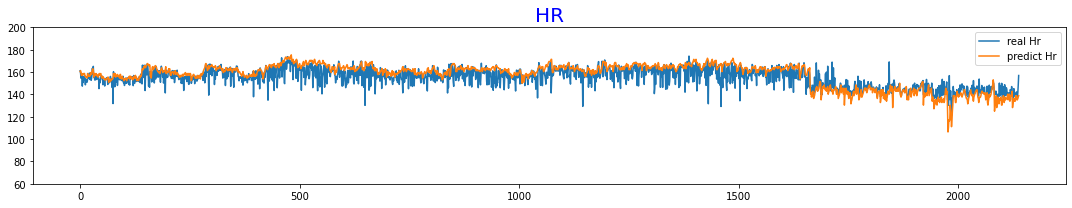

In [53]:
#use infant4 and infant5 as evaluation, others as train to create model, use mse and r2 to evaluate
final_res = {}
for i in range(1,10):
  
  a = [i, i+1]
  b = [m for m in range(1,11) if m not in a]
  a.extend(b)

  va = dfid[dfid.id.str.contains('^infant{0}_'.format(a[0]))]
  vb = dfid[dfid.id.str.contains('^infant{0}_'.format(a[1]))]
  
  vc_x = np.concatenate((va.iloc[:, 2:].values, vb.iloc[:, 2:].values))
  vc_y = np.concatenate((va.iloc[:, 1].values, vb.iloc[:, 1].values))


  ta = dfid[dfid.id.str.contains('^infant{0}_'.format(a[2]))]
  tb = dfid[dfid.id.str.contains('^infant{0}_'.format(a[3]))]
  tc = dfid[dfid.id.str.contains('^infant{0}_'.format(a[4]))]
  td = dfid[dfid.id.str.contains('^infant{0}_'.format(a[5]))]
  te = dfid[dfid.id.str.contains('^infant{0}_'.format(a[6]))]
  tf = dfid[dfid.id.str.contains('^infant{0}_'.format(a[7]))]
  tg = dfid[dfid.id.str.contains('^infant{0}_'.format(a[8]))]
  th = dfid[dfid.id.str.contains('^infant{0}_'.format(a[9]))]
  

  tc_x = np.concatenate((ta.iloc[:, 2:].values, tb.iloc[:, 2:].values, tc.iloc[:, 2:].values, td.iloc[:, 2:].values, te.iloc[:, 2:].values, tf.iloc[:, 2:].values, tg.iloc[:, 2:].values, th.iloc[:, 2:].values))
  tc_y = np.concatenate((ta.iloc[:, 1].values, tb.iloc[:, 1].values, tc.iloc[:, 1].values, td.iloc[:, 1].values, te.iloc[:, 1].values, tf.iloc[:, 1].values, tg.iloc[:, 1].values, th.iloc[:, 1].values))

  #print (tc_x.shape, tc_y.shape, vc_x.shape, vc_y.shape)
 

  train_X, test_X, train_y, test_y = split_data(tc_x, tc_y)
  #print (train_X.shape, test_X.shape, train_y.shape, test_y.shape)

  xgb_r = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

  # Fitting the model
  xgb_r.fit(train_X, train_y)


  # test
  pred = xgb_r.predict(test_X)
  # RMSE Computation
  #print (test_y)
  tmse = np.sqrt(MSE(test_y, pred))
  
  #print("test RMSE : % f" %(rmse))
  # r2square compution
  tr2 = r2_score(test_y, pred)
  #print("test R2 : % f" %(r2))

  # val
  pred = xgb_r.predict(vc_x)
  vmse = np.sqrt(MSE(vc_y, pred))
  #print("val RMSE : % f" %(rmse))
  # r2square compution
  vr2 = r2_score(vc_y, pred)
  #print("val R2 : % f" %(r2))

  #print (str(i) +'\t'+ str(tmse) +'\t'+ str(tr2) +'\t'+ str(vmse) +'\t'+ str(vr2))
  final_res["evaluation" + str(i)] = [tmse, tr2, vmse, vr2]

  #when infant4 and infant5 as validation
  if i == 4:
    plt.figure(figsize=(15.0, 3.0))
    plt.ylim((60,200))
    plt.title("HR", size=20, color="blue")
    plt.plot(pred, label='real Hr')
    plt.plot(vc_y, label='predict Hr')
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()


In [56]:
df_final_res = pd.DataFrame(final_res)
df_res_T = pd.DataFrame(df_final_res.values.T,columns=['TEST_RMSE', 'TEST_R2', 'VAL_RMSE', 'VAL_R2'], index=df_final_res.columns)
df_res_T

,TEST_RMSE,TEST_R2,VAL_RMSE,VAL_R2
evaluation1,7.38,0.50,8.67,0.76
evaluation2,7.54,0.17,8.72,0.78
evaluation3,8.94,0.65,8.19,0.80
evaluation4,8.96,0.86,8.47,0.73
evaluation5,10.14,-2.43,5.39,0.85
evaluation6,10.78,-1.17,8.12,0.82
evaluation7,10.92,-0.04,8.36,0.79
evaluation8,11.14,-0.01,7.94,0.80
evaluation9,11.72,-0.27,7.89,0.82
evaluation10,11.93,0.33,5.73,0.88
